In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt') #esta es una prueba

[nltk_data] Downloading package punkt to /home/leidy/nltk_data...


In [ ]:
dataset = pd.read_csv('./data.csv')
dataset.head()

### a) Análise Exploratória

#### Análise inicial dos dados

In [284]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [285]:
# Verificar o número de valores faltantes para cada coluna
valores_faltantes = dataset.isnull().sum()
print(valores_faltantes)

Sentence     0
Sentiment    0
dtype: int64


Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

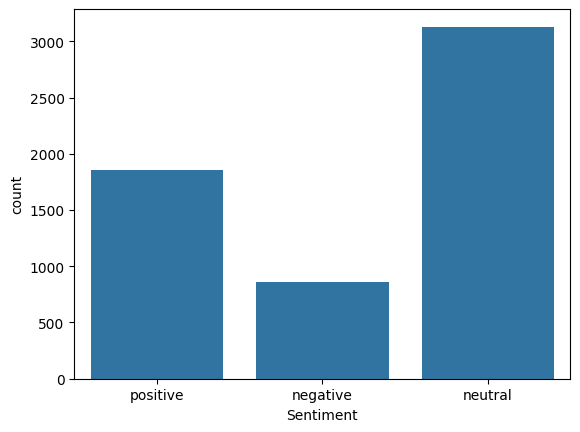

In [286]:
sns.countplot(x='Sentiment', data=dataset)
dataset['Sentiment'].value_counts()

In [287]:
#dataset['novacolumna']=[1,2,3]
#dataset
#tambem pode adicionar uma nova columna assim:
#dataset.insert(2,'nome',[1,2,3],True)

#### Explorando o comprimento dos textos (string)

In [288]:
dataset['length_text'] = dataset['Sentence'].apply(len)
dataset['length_text'].describe()

count    5842.000000
mean      117.020712
std        56.417790
min         9.000000
25%        72.000000
50%       107.000000
75%       150.000000
max       315.000000
Name: length_text, dtype: float64

##### Histograma

<Axes: xlabel='length_text', ylabel='Count'>

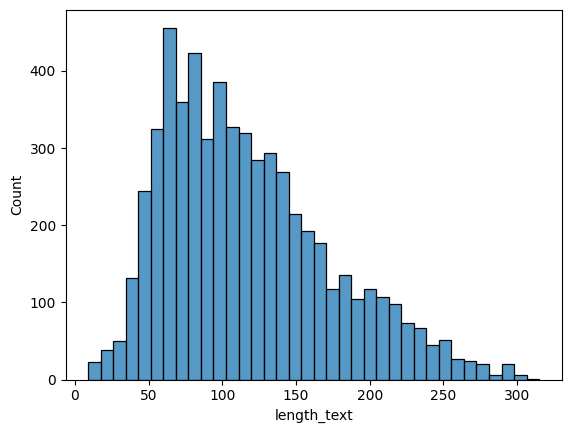

In [289]:
sns.histplot(dataset['length_text'])

##### Boxplot

<Axes: ylabel='length_text'>

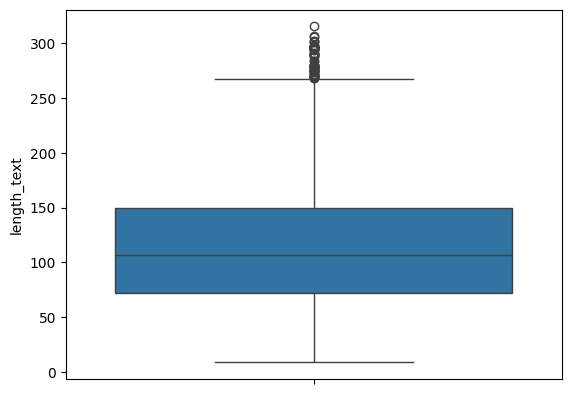

In [290]:
sns.boxplot(dataset['length_text'])

In [291]:
#corr_matrix = dataset['length_text'].corr(dataset['Sentiment'], method='pearson')


# Criando o heatmap
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#plt.title('Heatmap de Correlação')
#plt.show()

In [292]:
dataset_tokens = []
stopwords = nltk.corpus.stopwords.words('english')

for entry in dataset['Sentence']:
    tokens = nltk.tokenize.word_tokenize(entry)
    dataset_tokens.append( [word for word in tokens if word not in stopwords and word.isalpha()] ) 

dataset_tokens[1]

['ESI', 'lows', 'BK', 'real', 'possibility']

In [293]:
# Quantos adjetivos tem  cada linha
nltk.download('averaged_perceptron_tagger')
new_col=[]
for linha in dataset_tokens:
    norm_words=[word.lower() for word in linha if word.isalpha()]
    ps_tagger=nltk.pos_tag(norm_words)
    #print(ps_tagger)
    #for i in ps_tagger:
    #    print(i[1])
    n_adj=len([i for i in ps_tagger if i[1]=='JJ'])
    print(n_adj)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/josuhinrichs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


6
2
2
1
3
1
0
2
3
3
0
2
1
0
2
1
1
2
1
1
3
1
3
3
1
1
1
1
5
1
4
5
1
0
1
1
3
1
1
4
3
6
2
3
2
0
1
1
3
0
3
2
0
0
1
0
3
0
2
2
3
0
1
1
2
2
3
0
1
3
1
0
3
4
0
0
0
3
0
3
0
1
6
3
3
3
1
1
1
2
1
1
1
3
2
0
3
5
0
0
2
1
4
0
2
2
1
3
2
7
2
4
2
0
1
1
2
1
1
1
3
1
2
3
2
1
2
2
3
1
4
2
3
2
3
5
4
6
3
2
3
1
1
0
1
3
2
0
2
2
1
2
0
1
1
2
0
0
2
1
0
5
2
2
0
1
0
1
1
2
1
1
3
4
3
0
1
3
2
2
3
2
2
2
1
5
0
4
4
2
2
3
4
0
1
1
2
3
3
2
1
5
1
8
0
1
1
2
4
1
2
3
0
1
2
0
2
0
4
1
3
1
0
1
3
2
1
1
4
4
2
0
0
7
1
2
2
0
6
0
0
1
0
2
0
3
2
0
2
2
3
1
0
4
7
0
3
0
0
3
2
0
1
4
2
0
3
5
1
0
2
1
3
2
1
3
1
1
3
1
2
3
2
2
0
1
2
6
3
3
3
1
3
3
1
2
4
0
0
4
2
1
1
0
0
3
2
2
1
2
3
1
1
2
2
2
5
1
0
5
2
1
2
4
6
0
0
2
1
2
3
0
5
1
1
2
1
0
0
1
2
1
0
2
1
3
0
0
0
1
1
2
4
7
3
4
1
3
1
4
0
1
1
3
1
0
7
0
3
3
0
5
0
2
1
2
0
0
0
1
5
2
1
2
0
1
2
2
3
1
1
2
0
1
1
2
5
1
2
3
1
2
2
4
1
5
2
2
0
3
2
1
2
3
4
2
2
1
0
1
2
1
2
4
2
2
3
6
4
2
5
2
3
0
3
3
4
1
1
0
2
1
0
3
3
1
1
1
4
3
0
2
3
0
0
1
0
1
0
0
3
2
0
1
4
1
1
0
3
2
1
3
4
5
1
1
0
2
1
1
2
1
0
2
1
0
2
3
1
0
2
4
1
0
4
7
5
0
3
1


## b) Tratamento do dados